In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
def detect_target_column(df):
    candidates = ['target','y','Y','price','Price','Sale','Sales','sales','median_house_value','MedianHouseValue','target_var']
    for c in candidates:
        if c in df.columns:
            return c
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return numeric_cols[-1] if numeric_cols else None


In [3]:
def pca_errors(X, n_list):
    """Compute PCA reconstruction errors using eigenvectors of A^T A (SVD fallback)."""
    X = X.astype(float)
    mu = X.mean(axis=0)
    A = X - mu
    try:
        eigvals, eigvecs = np.linalg.eigh(A.T @ A)
        idx = np.argsort(eigvals)[::-1]
        eigvecs = eigvecs[:, idx]
    except Exception:
        # SVD fallback (numerically robust)
        U, S, Vt = np.linalg.svd(A, full_matrices=False)
        eigvecs = Vt.T
    results = {}
    for n in n_list:
        n_use = min(n, X.shape[1])
        E = eigvecs[:, :n_use]
        # ensure unit norm
        E = E / np.linalg.norm(E, axis=0, keepdims=True)
        W = A @ E                    # projections
        R = W @ E.T + mu             # reconstructed points
        err = float(np.sum((X - R)**2))
        results[n] = err
    return results

def standardize(X):
    mu = X.mean(axis=0)
    s = X.std(axis=0)
    s[s == 0] = 1.0
    return (X - mu) / s, mu, s

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def mse_loss(X, y, w):
    return float(np.mean((X @ w - y) ** 2))

def grad_mse(X, y, w):
    n = X.shape[0]
    return (2.0 / n) * (X.T @ (X @ w - y))

def gd_simple(X, y, eta=0.01, n_iter=1000):
    w = np.zeros(X.shape[1])
    losses = []
    for _ in range(n_iter):
        g = grad_mse(X, y, w)
        w = w - eta * g
        losses.append(mse_loss(X, y, w))
    return w, losses

def gd_momentum(X, y, eta=0.01, gamma=0.9, n_iter=1000):
    w = np.zeros(X.shape[1]); v = np.zeros_like(w); losses = []
    for _ in range(n_iter):
        g = grad_mse(X, y, w)
        v = gamma * v + eta * g        # vt+1 = γ vt + η ∇L(wt)
        w = w - v                      # wt+1 = wt - vt+1
        losses.append(mse_loss(X, y, w))
    return w, losses

def gd_nag(X, y, eta=0.01, gamma=0.9, n_iter=1000):
    w = np.zeros(X.shape[1]); v = np.zeros_like(w); losses = []
    for _ in range(n_iter):
        lookahead = w - gamma * v
        g = grad_mse(X, y, lookahead)   # gradient at (wt - γ vt)
        v = gamma * v + eta * g         # vt+1 = γ vt + η ∇L(wt - γ vt)
        w = w - v                       # wt+1 = wt - vt+1
        losses.append(mse_loss(X, y, w))
    return w, losses

In [5]:
# Cell 2 - load datasets (update paths if necessary)
paths = {
    "advertising": "advertising.csv",
    "faa_ai_prelim": "faa_ai_prelim.csv",
    "housing": "Housing.csv"
}
datasets = {}
targets = {}
for name, p in paths.items():
    p = Path(p)
    if not p.exists():
        print(f"WARNING: file not found: {p}")
        continue
    df = pd.read_csv(p)
    datasets[name] = df
    tgt = detect_target_column(df)
    targets[name] = tgt
    print(f"{name}: shape={df.shape}, target={tgt}")


advertising: shape=(200, 4), target=Sales
faa_ai_prelim: shape=(83, 42), target=GRND_INJ_UNK
housing: shape=(545, 13), target=price


In [7]:
# Cell 3 - PCA reconstruction errors + plots (one block per dataset)
out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)

n_list = [1,2,3,5,7,10,15]

for name, df in datasets.items():
    print(f"\n--- PCA: {name} ---")
    tgt = targets.get(name)
    Xdf = df.copy()
    if tgt in Xdf.columns:
        Xdf = Xdf.drop(columns=[tgt])
    Xnum = Xdf.select_dtypes(include=[np.number])
    Xnum = Xnum.dropna(axis=1, how='all')            # drop all-empty numeric cols
    if Xnum.shape[1] == 0:
        print("No numeric features found — skipping.")
        continue
    # impute remaining NaNs with column mean
    Xnum = Xnum.fillna(Xnum.mean()).values.astype(float)
    # trim n_list to available dims
    n_list_trim = [n for n in n_list if n <= Xnum.shape[1]] or [min(1, Xnum.shape[1])]
    results = pca_errors(Xnum, n_list_trim)
    for k in sorted(results):
        print(f"n={k}: error={results[k]:.6g}")


--- PCA: advertising ---
n=1: error=137786
n=2: error=35086.9
n=3: error=4.628e-26

--- PCA: faa_ai_prelim ---
n=1: error=27.7839
n=2: error=3.32031
n=3: error=1.32031
n=5: error=2.26798e-30
n=7: error=2.26798e-30
n=10: error=2.26798e-30

--- PCA: housing ---
n=1: error=1181.7
n=2: error=654.025
n=3: error=300.332
n=5: error=5.48008e-23


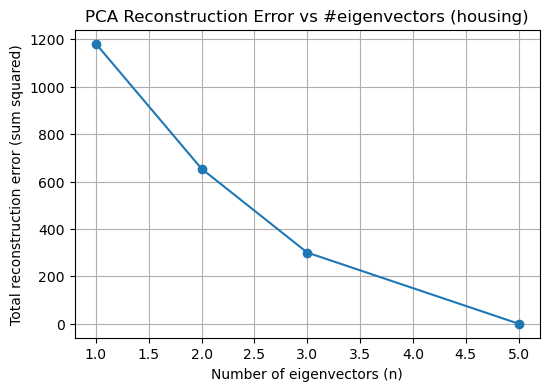

Saved plot to: \mnt\data\pca_recon_housing.png


In [8]:
 # plot
ks = sorted(results.keys())
vs = [results[k] for k in ks]
plt.figure(figsize=(6,4))
plt.plot(ks, vs, marker='o')
plt.title(f"PCA Reconstruction Error vs #eigenvectors ({name})")
plt.xlabel("Number of eigenvectors (n)")
plt.ylabel("Total reconstruction error (sum squared)")
plt.grid(True)
fname = out_dir / f"pca_recon_{name}.png"
plt.savefig(fname, bbox_inches='tight')
plt.show()
print("Saved plot to:", fname)

In [9]:
# Cell 4 - Gradient Descent comparisons + plots (one block per dataset)
out_dir = Path("/mnt/data")
out_dir.mkdir(parents=True, exist_ok=True)

for name, df in datasets.items():
    print(f"\n--- GD compare: {name} ---")
    tgt = targets.get(name)
    if tgt not in df.columns:
        print("Target column not found — skipping.")
        continue
    Xdf = df.drop(columns=[tgt]).select_dtypes(include=[np.number])
    if Xdf.shape[1] == 0:
        print("No numeric predictors — skipping.")
        continue
    # impute predictor NaNs with column mean
    X = Xdf.fillna(Xdf.mean()).values.astype(float)
    Xs, _, _ = standardize(X)
    Xb = add_bias(Xs)
    # prepare y
    y = pd.to_numeric(df[tgt], errors='coerce').fillna(df[tgt].mean()).values.astype(float)
    # choose learning rate heuristically (small if many features)
    eta = 0.01 if Xb.shape[1] < 50 else 1e-4
    n_iter = 1000
    w_s, losses_s = gd_simple(Xb, y, eta=eta, n_iter=n_iter)
    w_m, losses_m = gd_momentum(Xb, y, eta=eta, gamma=0.9, n_iter=n_iter)
    w_n, losses_n = gd_nag(Xb, y, eta=eta, gamma=0.9, n_iter=n_iter)
    # compute iterations to reach 10% initial loss (or None)
    thr = losses_s[0] * 0.1
    def it_to_10pct(L):
        L = np.array(L)
        idx = np.where(L <= thr)[0]
        return int(idx[0]) if idx.size else None
    print("chosen eta =", eta)
    print("iter to reach 10% initial loss -> simple:", it_to_10pct(losses_s),
          "momentum:", it_to_10pct(losses_m), "NAG:", it_to_10pct(losses_n))



--- GD compare: advertising ---
chosen eta = 0.01
iter to reach 10% initial loss -> simple: 60 momentum: 10 NAG: 10

--- GD compare: faa_ai_prelim ---
chosen eta = 0.01
iter to reach 10% initial loss -> simple: None momentum: None NAG: None

--- GD compare: housing ---
chosen eta = 0.01
iter to reach 10% initial loss -> simple: 78 momentum: 11 NAG: 11


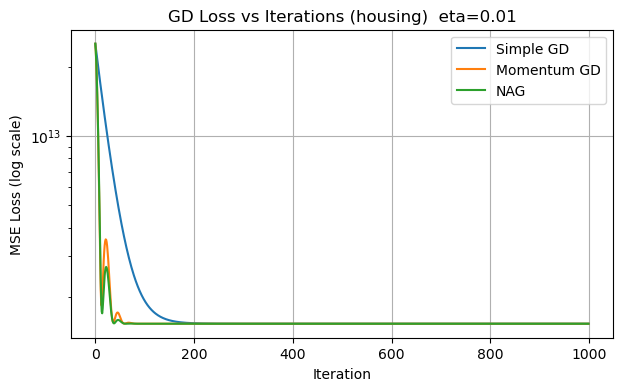

Saved plot to: \mnt\data\gd_losses_housing.png
final w_simple (first 8): [4766729.239684  717907.46666   123742.858369  569146.460231
  474895.808726  325033.038674]


In [10]:

    # plot losses
plt.figure(figsize=(7,4))
plt.plot(losses_s, label='Simple GD')
plt.plot(losses_m, label='Momentum GD')
plt.plot(losses_n, label='NAG')
plt.yscale('log')
plt.title(f"GD Loss vs Iterations ({name})  eta={eta}")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss (log scale)")
plt.legend()
plt.grid(True)
fname = out_dir / f"gd_losses_{name}.png"
plt.savefig(fname, bbox_inches='tight')
plt.show()
print("Saved plot to:", fname)




# optional: print final weights (first 8)
print("final w_simple (first 8):", np.round(w_s[:8], 6))